device = mps
Epoch   1/100  Train 0.1425  Val 0.0048
Epoch   2/100  Train 0.0049  Val 0.0040
Epoch   3/100  Train 0.0042  Val 0.0041
Epoch   4/100  Train 0.0039  Val 0.0033
Epoch   5/100  Train 0.0035  Val 0.0032
Epoch   6/100  Train 0.0033  Val 0.0030
Epoch   7/100  Train 0.0032  Val 0.0030
Epoch   8/100  Train 0.0031  Val 0.0028
Epoch   9/100  Train 0.0030  Val 0.0028
Epoch  10/100  Train 0.0030  Val 0.0029
Epoch  11/100  Train 0.0030  Val 0.0028
Epoch  12/100  Train 0.0029  Val 0.0027
Epoch  13/100  Train 0.0028  Val 0.0026
Epoch  14/100  Train 0.0028  Val 0.0026
Epoch  15/100  Train 0.0028  Val 0.0026
Epoch  16/100  Train 0.0027  Val 0.0025
Epoch  17/100  Train 0.0027  Val 0.0026
Epoch  18/100  Train 0.0027  Val 0.0026
Epoch  19/100  Train 0.0027  Val 0.0026
Epoch  20/100  Train 0.0027  Val 0.0026
Epoch  21/100  Train 0.0026  Val 0.0025
Epoch  22/100  Train 0.0026  Val 0.0025
Epoch  23/100  Train 0.0026  Val 0.0025
Epoch  24/100  Train 0.0026  Val 0.0026
Epoch  25/100  Train 0.0026

Eval: 100%|██████████| 49/49 [00:00<00:00, 307.92it/s]



File-level AUC = 0.4288


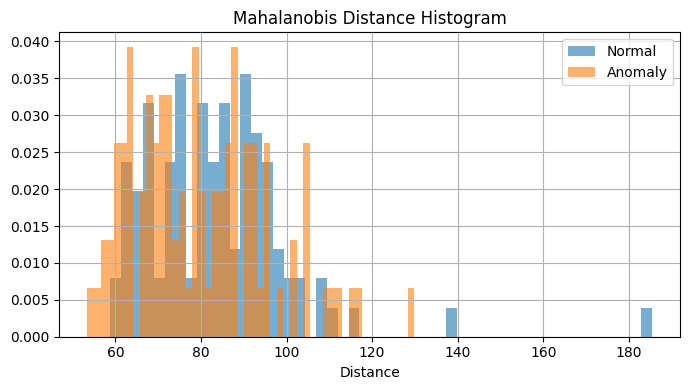

In [1]:
"""
DCASE‑style First‑Shot Autoencoder (MFCC版)
==========================================
Harada et al., EUSIPCO 2023 を参考にした全結合 Autoencoder による異常検知。
Log-Mel ではなく MFCC (e.g., 20次元) を使用。

・前処理  : STFT 64 ms / 50% Hop → MFCC → 5 フレーム連結
・モデル  : Linear‑AE (5×20=100次元 → 128 → ... → 8 → ... → 100)
・スコア  :  min{D_s , D_t}（Mahalanobis 距離）
・AUC     : ファイル単位（セグメント平均）
"""

# ------------------------------------------------------------------ #
# 1. 依存ライブラリ
# ------------------------------------------------------------------ #
import os, random, time, warnings
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

warnings.filterwarnings("ignore")

# ------------------------------------------------------------------ #
# 2. ハイパーパラメータ
# ------------------------------------------------------------------ #
SR          = 16_000
FRAME_LEN   = 1024            # 64 ms
HOP_LEN     = 512             # 50% hop
N_MFCC      = 16              # ← MFCC 次元数
N_FRAME     = 5
SEG_DIM     = N_MFCC * N_FRAME

BATCH_SIZE  = 256
EPOCHS      = 100
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else
                            "mps"  if torch.backends.mps.is_available()
                                    else "cpu")

# ------------------------------------------------------------------ #
# 3. 乱数固定
# ------------------------------------------------------------------ #
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# ------------------------------------------------------------------ #
# 4. データセット（MFCC版）
# ------------------------------------------------------------------ #
class MFCC5FrameDataset(Dataset):
    def __init__(self, folder, is_train=True):
        self.is_train = is_train
        self.segments = []

        file_paths = sorted([os.path.join(folder, f) for f in os.listdir(folder)
                             if f.endswith(".wav")])
        for fid, path in enumerate(file_paths):
            y, _ = librosa.load(path, sr=SR)
            mfcc = librosa.feature.mfcc(
                y=y, sr=SR, n_mfcc=N_MFCC, n_fft=FRAME_LEN,
                hop_length=HOP_LEN
            )
            mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)

            T = mfcc.shape[1] - (mfcc.shape[1] % N_FRAME)
            mfcc = mfcc[:, :T].reshape(N_MFCC, -1, N_FRAME)
            mfcc = mfcc.transpose(1, 0, 2).reshape(-1, SEG_DIM)

            domain = "source" if "_source_" in path else "target"
            label  = 1 if (not is_train and "_anomaly" in path) else 0

            for vec in mfcc:
                entry = dict(vec=vec.astype(np.float32),
                             domain=domain,
                             label=label,
                             fid=fid)
                self.segments.append(entry)

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        s = self.segments[idx]
        v = torch.from_numpy(s["vec"])
        if self.is_train:
            return v, s["domain"]
        else:
            return v, s["label"], s["domain"], s["fid"]

# ------------------------------------------------------------------ #
# 5. 全結合オートエンコーダ
# ------------------------------------------------------------------ #
class LinearAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(SEG_DIM, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 128),     nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 128),     nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128,   8)
        )
        self.decoder = nn.Sequential(
            nn.Linear( 8, 128),      nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 128),     nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 128),     nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, SEG_DIM)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# ------------------------------------------------------------------ #
# 6. 学習
# ------------------------------------------------------------------ #
def train(model, train_loader, val_loader):
    crit = nn.MSELoss()
    opt  = optim.Adam(model.parameters(), lr=1e-3)
    tr_hist, vl_hist = [], []

    for epoch in range(1, EPOCHS+1):
        model.train()
        tr_loss = 0.0
        for vec, _ in train_loader:
            vec = vec.to(DEVICE)
            loss = crit(model(vec), vec)
            opt.zero_grad(); loss.backward(); opt.step()
            tr_loss += loss.item()
        tr_loss /= len(train_loader)

        model.eval()
        vl_loss = 0.0
        with torch.no_grad():
            for vec, _ in val_loader:
                vec = vec.to(DEVICE)
                vl_loss += crit(model(vec), vec).item()
        vl_loss /= len(val_loader)

        tr_hist.append(tr_loss); vl_hist.append(vl_loss)
        print(f"Epoch {epoch:3d}/{EPOCHS}  Train {tr_loss:.4f}  Val {vl_loss:.4f}")
    return tr_hist, vl_hist

# ------------------------------------------------------------------ #
# 7. マハラノビス距離
# ------------------------------------------------------------------ #
def stats_by_domain(model, loader):
    model.eval(); errs = []
    with torch.no_grad():
        for vec, _ in loader:
            vec = vec.to(DEVICE)
            diff = (vec - model(vec)).cpu().numpy()
            errs.append(diff)
    errs = np.concatenate(errs, 0)
    mu  = errs.mean(0, keepdims=True)
    cov = np.cov(errs.T) + 1e-6*np.eye(SEG_DIM)
    inv = np.linalg.inv(cov)
    return mu, inv

def maha(vec, mu, inv):
    d = vec - mu
    return float(d @ inv @ d.T)

# ------------------------------------------------------------------ #
# 8. 評価
# ------------------------------------------------------------------ #
def evaluate(model, loader, mu_s, inv_s, mu_t, inv_t):
    model.eval()
    seg_scores, seg_labels, seg_fids = [], [], []

    with torch.no_grad():
        for vec, label, domain, fid in tqdm(loader, desc="Eval"):
            vec = vec.to(DEVICE)
            diff = (vec - model(vec)).cpu().numpy()
            for v, f in zip(diff, fid.numpy()):
                Ds = maha(v, mu_s, inv_s)
                Dt = maha(v, mu_t, inv_t)
                seg_scores.append(min(Ds, Dt))
            seg_labels.extend(label.numpy())
            seg_fids.extend(fid.numpy())

    file_scores = {}
    file_labels = {}
    for sc, lb, fid in zip(seg_scores, seg_labels, seg_fids):
        file_scores.setdefault(fid, []).append(sc)
        file_labels[fid] = lb
    scores = np.array([np.mean(v) for v in file_scores.values()])
    labels = np.array([file_labels[k] for k in sorted(file_scores)])

    auc = roc_auc_score(labels, scores)
    print(f"\nFile-level AUC = {auc:.4f}")

    plt.figure(figsize=(7,4))
    plt.hist(scores[labels==0], 50, alpha=.6, label="Normal", density=True)
    plt.hist(scores[labels==1], 50, alpha=.6, label="Anomaly",density=True)
    plt.title("Mahalanobis Distance Histogram"); plt.xlabel("Distance")
    plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------ #
# 9. メイン処理
# ------------------------------------------------------------------ #
if __name__ == "__main__":
    print("device =", DEVICE)
    set_seed()

    train_folders = ["dev/valve/train"]  # ← 必要に応じてパス変更
    train_dss = [MFCC5FrameDataset(f, True) for f in train_folders]
    train_full = ConcatDataset(train_dss)

    tr_size = int(0.8 * len(train_full))
    va_size = len(train_full) - tr_size
    train_ds, val_ds = random_split(train_full, [tr_size, va_size])

    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

    test_ds = MFCC5FrameDataset("dev/valve/test", is_train=False)
    test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False)

    ae = LinearAE().to(DEVICE)
    train_hist, val_hist = train(ae, train_loader, val_loader)

    def domain_subset(dataset, dom):
        idx = [i for i, (_, d) in enumerate(dataset) if d == dom]
        return torch.utils.data.Subset(dataset, idx)

    src_loader = DataLoader(domain_subset(train_ds, "source"), BATCH_SIZE, shuffle=False)
    tgt_loader = DataLoader(domain_subset(train_ds, "target"), BATCH_SIZE, shuffle=False)

    mu_s, inv_s = stats_by_domain(ae, src_loader)
    mu_t, inv_t = stats_by_domain(ae, tgt_loader)

    evaluate(ae, test_loader, mu_s, inv_s, mu_t, inv_t)

device = mps
Epoch   1/100  Train 0.3768  Val 0.0179
Epoch   2/100  Train 0.0131  Val 0.0110
Epoch   3/100  Train 0.0105  Val 0.0092
Epoch   4/100  Train 0.0088  Val 0.0078
Epoch   5/100  Train 0.0080  Val 0.0074
Epoch   6/100  Train 0.0077  Val 0.0072
Epoch   7/100  Train 0.0076  Val 0.0071
Epoch   8/100  Train 0.0074  Val 0.0070
Epoch   9/100  Train 0.0072  Val 0.0068
Epoch  10/100  Train 0.0071  Val 0.0066
Epoch  11/100  Train 0.0070  Val 0.0065
Epoch  12/100  Train 0.0068  Val 0.0064
Epoch  13/100  Train 0.0067  Val 0.0064
Epoch  14/100  Train 0.0066  Val 0.0063
Epoch  15/100  Train 0.0066  Val 0.0061
Epoch  16/100  Train 0.0065  Val 0.0060
Epoch  17/100  Train 0.0062  Val 0.0057
Epoch  18/100  Train 0.0053  Val 0.0044
Epoch  19/100  Train 0.0043  Val 0.0041
Epoch  20/100  Train 0.0041  Val 0.0040
Epoch  21/100  Train 0.0041  Val 0.0039
Epoch  22/100  Train 0.0040  Val 0.0038
Epoch  23/100  Train 0.0039  Val 0.0038
Epoch  24/100  Train 0.0038  Val 0.0037
Epoch  25/100  Train 0.0038

Eval: 100%|██████████| 13/13 [00:00<00:00, 43.11it/s]



File-level AUC = 0.4398


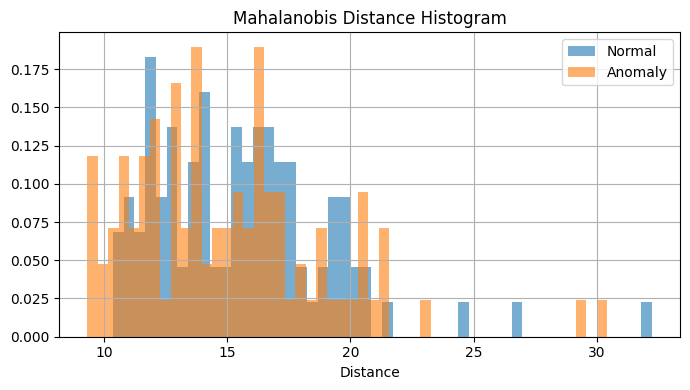

In [2]:
"""
Conv1d-AE for MFCC Time-Series Anomaly Detection
================================================
Harada et al., EUSIPCO 2023 風の異常検知を参考に、Conv1d を使用して
MFCC の時間的変化を捉える構成に変更。
"""

# ------------------------------------------------------------------ #
# 1. 依存ライブラリ
# ------------------------------------------------------------------ #
import os, random, time, warnings
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

warnings.filterwarnings("ignore")

# ------------------------------------------------------------------ #
# 2. ハイパーパラメータ
# ------------------------------------------------------------------ #
SR          = 16_000
FRAME_LEN   = 1024
HOP_LEN     = 512
N_MFCC      = 16

BATCH_SIZE  = 16  # 長さが可変なため小さめ
EPOCHS      = 100
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else
                            "mps"  if torch.backends.mps.is_available()
                                    else "cpu")

# ------------------------------------------------------------------ #
# 3. 乱数固定
# ------------------------------------------------------------------ #
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# ------------------------------------------------------------------ #
# 4. データセット（MFCC全時系列）
# ------------------------------------------------------------------ #
class MFCCDataset(Dataset):
    def __init__(self, folder, is_train=True):
        self.is_train = is_train
        self.data = []

        file_paths = sorted([os.path.join(folder, f) for f in os.listdir(folder)
                             if f.endswith(".wav")])
        for fid, path in enumerate(file_paths):
            y, _ = librosa.load(path, sr=SR)
            mfcc = librosa.feature.mfcc(
                y=y, sr=SR, n_mfcc=N_MFCC, n_fft=FRAME_LEN,
                hop_length=HOP_LEN
            )
            mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)

            domain = "source" if "_source_" in path else "target"
            label  = 1 if (not is_train and "_anomaly" in path) else 0

            self.data.append(dict(
                vec=mfcc.astype(np.float32),
                domain=domain,
                label=label,
                fid=fid
            ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        s = self.data[idx]
        v = torch.from_numpy(s["vec"])  # shape: (20, T)
        if self.is_train:
            return v, s["domain"]
        else:
            return v, s["label"], s["domain"], s["fid"]

# ------------------------------------------------------------------ #
# 5. Conv1d オートエンコーダ
# ------------------------------------------------------------------ #
class Conv1dAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(N_MFCC, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=5, padding=2), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(32, N_MFCC, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ------------------------------------------------------------------ #
# 6. 学習
# ------------------------------------------------------------------ #
def train(model, train_loader, val_loader):
    crit = nn.MSELoss()
    opt  = optim.Adam(model.parameters(), lr=1e-3)
    tr_hist, vl_hist = [], []

    for epoch in range(1, EPOCHS+1):
        model.train()
        tr_loss = 0.0
        for vec, _ in train_loader:
            vec = vec.to(DEVICE)
            rec = model(vec)
            loss = crit(rec, vec)
            opt.zero_grad(); loss.backward(); opt.step()
            tr_loss += loss.item()
        tr_loss /= len(train_loader)

        model.eval()
        vl_loss = 0.0
        with torch.no_grad():
            for vec, _ in val_loader:
                vec = vec.to(DEVICE)
                rec = model(vec)
                vl_loss += crit(rec, vec).item()
        vl_loss /= len(val_loader)

        tr_hist.append(tr_loss); vl_hist.append(vl_loss)
        print(f"Epoch {epoch:3d}/{EPOCHS}  Train {tr_loss:.4f}  Val {vl_loss:.4f}")
    return tr_hist, vl_hist

# ------------------------------------------------------------------ #
# 7. マハラノビス距離
# ------------------------------------------------------------------ #
def stats_by_domain(model, loader):
    model.eval(); errs = []
    with torch.no_grad():
        for vec, _ in loader:
            vec = vec.to(DEVICE)
            rec = model(vec)
            diff = (vec - rec).cpu().numpy()  # (B, 20, T)
            B, C, T = diff.shape
            diff = diff.transpose(0, 2, 1).reshape(-1, C)  # (B*T, 20)
            errs.append(diff)
    errs = np.concatenate(errs, 0)
    mu  = errs.mean(0, keepdims=True)
    cov = np.cov(errs.T) + 1e-6*np.eye(N_MFCC)
    inv = np.linalg.inv(cov)
    return mu, inv

def maha(vec, mu, inv):
    d = vec - mu
    return float(d @ inv @ d.T)

# ------------------------------------------------------------------ #
# 8. 評価
# ------------------------------------------------------------------ #
def evaluate(model, loader, mu_s, inv_s, mu_t, inv_t):
    model.eval()
    file_scores = {}
    file_labels = {}

    with torch.no_grad():
        for vec, label, domain, fid in tqdm(loader, desc="Eval"):
            vec = vec.to(DEVICE)
            rec = model(vec)
            diff = (vec - rec).cpu().numpy()  # (B, 20, T)
            B, C, T = diff.shape
            diff = diff.transpose(0, 2, 1).reshape(B * T, C)

            for b in range(B):
                start = b * T
                end = start + T
                scores = [min(maha(d, mu_s, inv_s), maha(d, mu_t, inv_t)) for d in diff[start:end]]
                score = np.mean(scores)
                file_scores[fid[b].item()] = score
                file_labels[fid[b].item()] = label[b].item()

    scores = np.array([file_scores[k] for k in sorted(file_scores)])
    labels = np.array([file_labels[k] for k in sorted(file_labels)])

    auc = roc_auc_score(labels, scores)
    print(f"\nFile-level AUC = {auc:.4f}")

    plt.figure(figsize=(7,4))
    plt.hist(scores[labels==0], 50, alpha=.6, label="Normal", density=True)
    plt.hist(scores[labels==1], 50, alpha=.6, label="Anomaly", density=True)
    plt.title("Mahalanobis Distance Histogram"); plt.xlabel("Distance")
    plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------ #
# 9. メイン処理
# ------------------------------------------------------------------ #
if __name__ == "__main__":
    print("device =", DEVICE)
    set_seed()

    train_folders = ["dev/valve/train"]
    train_dss = [MFCCDataset(f, True) for f in train_folders]
    train_full = ConcatDataset(train_dss)

    tr_size = int(0.8 * len(train_full))
    va_size = len(train_full) - tr_size
    train_ds, val_ds = random_split(train_full, [tr_size, va_size])

    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

    test_ds = MFCCDataset("dev/valve/test", is_train=False)
    test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False)

    ae = Conv1dAE().to(DEVICE)
    train_hist, val_hist = train(ae, train_loader, val_loader)

    def domain_subset(dataset, dom):
        idx = [i for i, (x, d) in enumerate(dataset) if d == dom]
        return torch.utils.data.Subset(dataset, idx)

    src_loader = DataLoader(domain_subset(train_ds, "source"), BATCH_SIZE, shuffle=False)
    tgt_loader = DataLoader(domain_subset(train_ds, "target"), BATCH_SIZE, shuffle=False)

    mu_s, inv_s = stats_by_domain(ae, src_loader)
    mu_t, inv_t = stats_by_domain(ae, tgt_loader)

    evaluate(ae, test_loader, mu_s, inv_s, mu_t, inv_t)
